В работе ниже мы проверяем поведение портфеля в условиях медвежьего рынка на основе теорий Марковица.


In [ ]:
#МАРКОВИЦ
import pandas as pd

#progressBar
from time import sleep
from tqdm import tqdm

import glob

#Подготовим данные для анализа. Функция глоб считывает, что лежит в папке, сохраняет путь,
#а потом с помощью цикла склеивает все еженедельные цены акций на конец дня за 3 года в единый файл


def matrixMaker():
    files = glob.glob(r"Price_3Y/*.csv")
    returnDF = pd.DataFrame()

    for file in files:
            data = pd.read_csv(file, sep = ";")

            data[data["<TICKER>"][0]] = data["<CLOSE>"]
            FinalDF = data[[data["<TICKER>"][0]]]

            returnDF = pd.concat([returnDF, FinalDF], axis=1)

    returnDF.to_excel("price_history_tickers.xlsx", index = False)


matrixMaker()

#Подготовим данные для анализа
closeData = pd.read_excel("price_history_tickers.xlsx")


#1. Заполним пропуски медианными значениями цен соответствующих тикеров
closeData = closeData.fillna(closeData.median ())

#2. Находим logreturns на скользящие средние на -1 период
import numpy as np
logReturns_closedData = np.log(closeData/closeData.shift(1)).dropna()

#3. Находим ковматрицу в пересчете на 52 торговых недели
cov_closedData = logReturns_closedData.cov()*52

#4. Находим дисперсию всего портфеля (риск портфеля в квадрате). Готовим функцию
def variance(weights, cov_closedData):
      variance = weights.T @ cov_closedData @ weights
      return variance



#5. Устанавливаем ограничения
constraints = {"type": "eq", "fun" : lambda weights: np.sum(weights)-1} #Ограничение, что сумма всех долей должна быть = 1
bounds = [(0,1) for _ in range(len(closeData.columns))] #Границы для весов каждого актива (столько же сколько тикеров, т.е. 17). Доля в портфеле от 0 до 1

#6. Задаём изначальные значения weights равными долями, зависимо от количества акций в портфеле перед оптимизацией
weights = np.array([1/len(closeData.columns)]*len(closeData.columns))

#7. Непосредственно определяем доли каждой бумаги в портфеле
#Минимизируем функцию дисперсии портфеля variance по весам
from scipy.optimize import minimize
res = minimize(variance, weights, args=(cov_closedData), method='SLSQP', constraints = constraints, bounds = bounds)

optimal_weights = res.x


print("Optimal Weights:")
for ticker, weight in zip(closeData.columns, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
ABRD: 0.0087
EELT: 0.0271
FIXP: 0.0250
HNFG: 0.7038
KCHE: 0.0059
LVHK: 0.0020
MDMG: 0.0237
MGTSP: 0.0093
MTSS: 0.0232
RGSS: 0.0028
SELG: 0.0053
SFIN: 0.0223
SMLT: 0.0123
TGKN: 0.0054
TTLK: 0.0034
WTCM: 0.0134
WUSH: 0.0989
YNDX: 0.0075


Задача нахождения оптимального портфеля - это максимизация коэффициента Шарпа (то есть отношения приемлемой доходности портфеля к риску (СКО) портфеля). Чем ниже риск, тем выше коэффицент Шарпа.

Выше мы нашли доли акций в портфеле, при котором его волатильность (т.е. дисперсия) будет минимальна

In [ ]:

#8. Находим ожидаемую среднюю доходность портфеля. 
#Вместо средней возьмём медиану, чтобы выбросы минимально влияли на результат
def expected_return(optimal_weights, logReturns_closedData):
      portfolioReturns = np.sum(logReturns_closedData.mean()*optimal_weights)*52
      return portfolioReturns

porfolioReturn = expected_return(optimal_weights, logReturns_closedData)
#Вычисляем риск как корень из дисперсии портфеля
risk = np.sqrt(variance(optimal_weights, cov_closedData))
#Возьмем текущую безрисковую ставку = 17% и переведём ее в недельные доходности
risk_free_rate = 0.17/52
      
#6. Находим коэффициент Шарпа, его нам нужно максимизировать
def sharp(porfolioReturn, risk, risk_free_rate):
      net_return = porfolioReturn - risk_free_rate #Находим чистую доходность, которую мы получим после вычета безрисковой ставки
      sharpRatio = net_return / risk
      return sharpRatio


optimal_portfolio_return = expected_return(optimal_weights, logReturns_closedData)
optimal_portfolio_volatility = np.sqrt(variance(optimal_weights, cov_closedData))
optimal_sharpe_ratio = sharp(porfolioReturn, risk, risk_free_rate)



print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: -0.0024
Expected Volatility: 0.0205
Sharpe Ratio: -0.2776


Теорию марковица можно доказать и методом Монте-Карло

Его суть сводится к генерации множества портфелей с различными характеристиками риск-доходности и визуализации в виде диаграммы рассеяния.

Затем из облака портфелей берем с самым оптимальным соотношением риск-доходности

Text(0.5, 1.0, 'Облако портфелей')

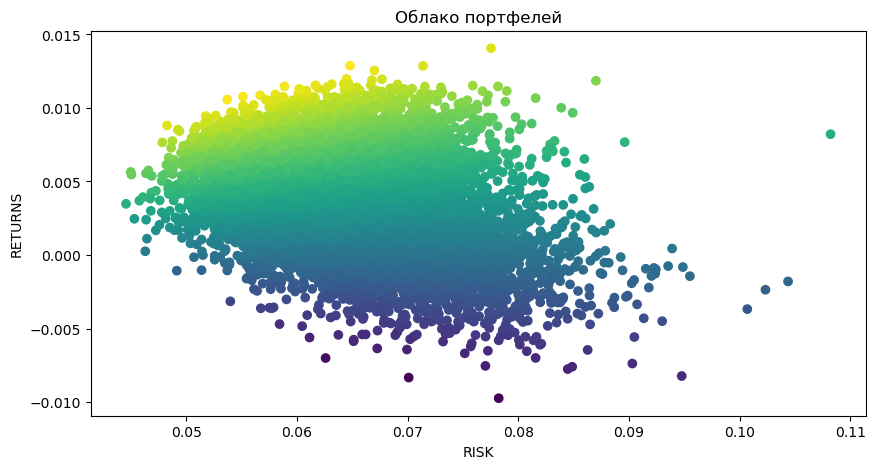

In [ ]:
#Сгенерируем 10.000 портфелей и визуализируем результат
import matplotlib.pyplot as plt



portfolioAmount = 10000

portfolioWeights = []
portfolioRisks = []
portfolioReturns = []
portfolioSharpe = []


def PortfolioGenerator(portfolioAmount):
    
    for i in range(portfolioAmount):
        weights = np.random.random_sample(len(closeData.columns))
        
        weights = np.round(weights/np.sum(weights), 3)

        risk = np.sqrt(variance(weights, cov_closedData))

        returns = expected_return(weights, logReturns_closedData)
        
        sharpe = sharp(porfolioReturn, risk, risk_free_rate)

        portfolioWeights.append(weights)
        portfolioRisks.append(risk)
        portfolioReturns.append(returns)
        portfolioSharpe.append(sharpe)
        data = [portfolioWeights, portfolioRisks, portfolioReturns, portfolioSharpe]
    return data

data = PortfolioGenerator(portfolioAmount)



potfolios = pd.DataFrame(data = data).T
potfolios.columns = ["WEIGHTS", "RISK", "RETURN", "SHARPE"]
potfolios


#Нарисуем кривую эффективных портфелей

plt.figure(figsize = (10,5))

plt.scatter(y = potfolios["RETURN"], x = potfolios["RISK"], c = potfolios["RETURN"]/potfolios["RISK"])

plt.ylabel("RETURNS")
plt.xlabel("RISK")
plt.title('Облако портфелей')



In [ ]:
tickers = closeData.columns

#Оставим портфели только с положительной доходностью
potfolios = potfolios.query('RETURN>0')

mininamalRiskPortfolio = potfolios[potfolios['RISK']==potfolios['RISK'].min()].values[0]
maxReturnPortfolio = potfolios[potfolios['RETURN']==potfolios['RETURN'].max()].values[0]
maxSharpePortfolio = potfolios[potfolios['SHARPE']==potfolios['SHARPE'].max()].values[0]

mininamalRiskPortfolioweights = mininamalRiskPortfolio[0]
maxReturnPortfolioweights = maxReturnPortfolio[0]
maxSharpePortfolioweights = maxSharpePortfolio[0]


print("Оптимальный портфель минимального риска: ")

for i in range(len(tickers)):
    print(tickers[i], ":",mininamalRiskPortfolioweights[i])

print(f"\nРИСК ПОРТФЕЛЯ: {np.round(mininamalRiskPortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {np.round(mininamalRiskPortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {np.round(mininamalRiskPortfolio[3]*100, 2):.4f}%\n")


print("Оптимальный портфель максимальной доходности: ")

for i in range(len(tickers)):
    print(tickers[i], ":",maxReturnPortfolioweights[i])
 
print(f"РИСК ПОРТФЕЛЯ: {round(maxReturnPortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {round(maxReturnPortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {round(maxReturnPortfolio[3]*100, 2):.4f}%\n")


print("Оптимальный портфель максимального Шарпа: ")

maxSharpePortfolioWEIGHTS = [tickers, maxSharpePortfolio[0]]

for i in range(len(tickers)):
    print(tickers[i], ":",maxSharpePortfolioweights[i])

print(f"РИСК ПОРТФЕЛЯ: {round(maxSharpePortfolio[1]*100, 2):.4f}%")
print(f"ДОХОДНОСТЬ ПОРТФЕЛЯ: {round(maxSharpePortfolio[2]*100, 2):.4f}%")
print(f"КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: {round(maxSharpePortfolio[3]*100, 2):.4f}%")



Оптимальный портфель минимального риска: 
ABRD : 0.108
EELT : 0.114
FIXP : 0.038
HNFG : 0.165
KCHE : 0.01
LVHK : 0.011
MDMG : 0.151
MGTSP : 0.021
MTSS : 0.098
RGSS : 0.014
SELG : 0.017
SFIN : 0.102
SMLT : 0.042
TGKN : 0.033
TTLK : 0.008
WTCM : 0.015
WUSH : 0.009
YNDX : 0.045

РИСК ПОРТФЕЛЯ: 4.4600%
ДОХОДНОСТЬ ПОРТФЕЛЯ: 0.3500%
КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: -12.7900%

Оптимальный портфель максимальной доходности: 
ABRD : 0.074
EELT : 0.005
FIXP : 0.02
HNFG : 0.038
KCHE : 0.135
LVHK : 0.044
MDMG : 0.006
MGTSP : 0.058
MTSS : 0.027
RGSS : 0.001
SELG : 0.076
SFIN : 0.063
SMLT : 0.124
TGKN : 0.093
TTLK : 0.019
WTCM : 0.086
WUSH : 0.005
YNDX : 0.126
РИСК ПОРТФЕЛЯ: 7.7500%
ДОХОДНОСТЬ ПОРТФЕЛЯ: 1.4100%
КОЭФФИЦИЕНТ ШАРПА ПОРТФЕЛЯ: -7.3500%

Оптимальный портфель максимального Шарпа: 
ABRD : 0.034
EELT : 0.043
FIXP : 0.031
HNFG : 0.0
KCHE : 0.179
LVHK : 0.0
MDMG : 0.021
MGTSP : 0.025
MTSS : 0.007
RGSS : 0.055
SELG : 0.024
SFIN : 0.082
SMLT : 0.046
TGKN : 0.159
TTLK : 0.23
WTCM : 0.04
WUSH : 0.019
YN